In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")



In [2]:
df = pd.read_csv('Ashrae_cleaned.csv')
df.head()

,Season,Building type,Cooling startegy_building level,Climate,Thermal sensation,Koppen climate classification,Clo,Met,Thermal preference,Relative humidity,Air velocity,Country,Air temperature
0,Summer,Office,Air Conditioned,Humid subtropical,-1.3,Cfa,0.57,1.0,Uncomfortable Cold,36.8,0.27,USA,24.3
1,Summer,Office,Air Conditioned,Humid subtropical,-1.4,Cfa,0.57,1.1,Uncomfortable Cold,33.1,0.09,USA,25.7
2,Summer,Office,Air Conditioned,Humid subtropical,0.6,Cfa,0.57,1.1,Uncomfortable Cold,34.9,0.06,USA,24.6
3,Summer,Office,Air Conditioned,Humid subtropical,0.5,Cfa,0.57,1.0,Uncomfortable Cold,31.7,0.13,USA,26.4
4,Summer,Office,Air Conditioned,Humid subtropical,1.6,Cfa,0.57,1.0,Uncomfortable Cold,33.3,0.07,USA,25.0


In [3]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['Season', 'Building type', 'Cooling startegy_building level', 'Climate',
       'Koppen climate classification', 'Thermal preference', 'Country'],
      dtype='object')

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [5]:
df.head()

,Season,Building type,Cooling startegy_building level,Climate,Thermal sensation,Koppen climate classification,Clo,Met,Thermal preference,Relative humidity,Air velocity,Country,Air temperature
0,2,2,0,5,-1.3,5,0.57,1.0,1,36.8,0.27,15,24.3
1,2,2,0,5,-1.4,5,0.57,1.1,1,33.1,0.09,15,25.7
2,2,2,0,5,0.6,5,0.57,1.1,1,34.9,0.06,15,24.6
3,2,2,0,5,0.5,5,0.57,1.0,1,31.7,0.13,15,26.4
4,2,2,0,5,1.6,5,0.57,1.0,1,33.3,0.07,15,25.0


In [6]:
for column in categorical_columns:
    print(f"Unique values in {column} after encoding:", df[column].unique())


Unique values in Season after encoding: [2 3 1 0]
Unique values in Building type after encoding: [2 3 1 0 4]
Unique values in Cooling startegy_building level after encoding: [0 2 3 1]
Unique values in Climate after encoding: [ 5 12  2  3 11  9 13 10  6  8  1  0 14  7  4]
Unique values in Koppen climate classification after encoding: [ 5  2  3  7  0  6  8  1 10 11  4  9 12]
Unique values in Thermal preference after encoding: [1 0 2]
Unique values in Country after encoding: [15  6  7 10  0  9 14  3 12 11  5  1  8  4 13  2]


In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Load dataset (Assuming df is already loaded)
X = df.drop(columns=['Thermal preference'])
y = df['Thermal preference']

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert target variable to categorical (one-hot encoding)
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the DNN model (simplified)
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=256, max_value=512, step=128),
                    input_shape=(X_train.shape[1],), activation='relu'))

    for i in range(hp.Int('num_layers', 1, 4)):  # Vary number of layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=128, max_value=256, step=64), activation='relu'))

    model.add(Dense(units=y.shape[1], activation='softmax'))

    # Compile model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning using Keras Tuner's Hyperband
tuner = kt.Hyperband(
    build_model, 
    objective='val_accuracy', 
    max_epochs=30, 
    factor=4, 
    directory='hyperband_results', 
    project_name='thermal_preference'
)

# Start hyperparameter search
tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Cross-validation (using scikeras KerasClassifier)
def create_keras_model():
    model = build_model(best_hps)  # Use best hyperparameters from tuner
    return model

keras_clf = KerasClassifier(model=create_keras_model, epochs=50, batch_size=32, verbose=0)

# 5-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


Reloading Tuner from hyperband_results\thermal_preference\tuner0.json
Epoch 1/75
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7748 - loss: 0.5300 - val_accuracy: 0.7719 - val_loss: 0.5742
Epoch 2/75
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7801 - loss: 0.5176 - val_accuracy: 0.7651 - val_loss: 0.5810
Epoch 3/75
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7749 - loss: 0.5234 - val_accuracy: 0.7687 - val_loss: 0.5753
Epoch 4/75
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7832 - loss: 0.5103 - val_accuracy: 0.7677 - val_loss: 0.5707
Epoch 5/75
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7804 - loss: 0.5131 - val_accuracy: 0.7652 - val_loss: 0.5716
Epoch 6/75
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7851 - loss: 0.5072 - val_accuracy: 0.7624 - val_loss: 0.5846
Epoch 7/75
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7804 - loss: 0.5088 - val_accuracy: 0.7669 - val_loss: 0.5755
Epoch 8/75
1225/1225

In [31]:
# Save the best model after hyperparameter tuning
best_model.save("DNN_tuned.h5")

best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,259 (2.16 MB)

 Trainable params: 188,419 (736.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 376,840 (1.44 MB)

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Separate features and target
X = df.drop(columns=['Thermal preference'])
y = df['Thermal preference']

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert target variable to categorical (one-hot encoding)
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Deep Neural Network (DNN) Model
model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='relu'),  # Input layer with ReLU
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(256, activation='relu'),  # Hidden layer with ReLU
    Dropout(0.3),
    Dense(128, activation='relu'),  # Hidden layer with ReLU
    Dropout(0.3),
    Dense(64, activation='relu'),  # Hidden layer with ReLU
    Dropout(0.3),
    Dense(32, activation='relu'),  # Hidden layer with ReLU
    Dense(y.shape[1], activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6722 - loss: 0.7822 - val_accuracy: 0.7479 - val_loss: 0.6335
Epoch 2/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7356 - loss: 0.6445 - val_accuracy: 0.7535 - val_loss: 0.5967
Epoch 3/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7454 - loss: 0.6184 - val_accuracy: 0.7633 - val_loss: 0.5922
Epoch 4/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7466 - loss: 0.6111 - val_accuracy: 0.7592 - val_loss: 0.5965
Epoch 5/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7506 - loss: 0.5988 - val_accuracy: 0.7576 - val_loss: 0.5942
Epoch 6/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7490 - loss: 0.6018 - val_accuracy: 0.7621 - val_loss: 0.5813
Epoch 7/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7518 - loss: 0.5946 - val_accuracy: 0.7611 - val_loss: 0.5797
Epoch 8/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7537 - loss: 0.5950 - 

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.utils import to_categorical

# Separate features and target
X = df.drop(columns=['Thermal preference'])
y = df['Thermal preference']

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert target variable to categorical (one-hot encoding)
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Deep Neural Network (DNN) Model with LeakyReLU
model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],)),  # Input layer
    LeakyReLU(alpha=0.1),  # LeakyReLU activation with alpha=0.1
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(256),
    LeakyReLU(alpha=0.1),  # LeakyReLU activation
    Dropout(0.3),
    Dense(128),
    LeakyReLU(alpha=0.1),  # LeakyReLU activation
    Dropout(0.3),
    Dense(64),
    LeakyReLU(alpha=0.1),  # LeakyReLU activation
    Dropout(0.3),
    Dense(32),
    LeakyReLU(alpha=0.1),  # LeakyReLU activation
    Dense(y.shape[1], activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6854 - loss: 0.7527 - val_accuracy: 0.7455 - val_loss: 0.6223
Epoch 2/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7394 - loss: 0.6371 - val_accuracy: 0.7414 - val_loss: 0.6089
Epoch 3/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7437 - loss: 0.6238 - val_accuracy: 0.7527 - val_loss: 0.5939
Epoch 4/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7417 - loss: 0.6197 - val_accuracy: 0.7478 - val_loss: 0.6067
Epoch 5/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7475 - loss: 0.6084 - val_accuracy: 0.7514 - val_loss: 0.5914
Epoch 6/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7492 - loss: 0.6059 - val_accuracy: 0.7582 - val_loss: 0.5814
Epoch 7/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7474 - loss: 0.6022 - val_accuracy: 0.7648 - val_loss: 0.5764
Epoch 8/50
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7453 - loss: 0.5995 - 

In [39]:
from sklearn.metrics import classification_report
import numpy as np

# Predict classes for the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      6153
           1       0.77      0.80      0.78      4046
           2       0.73      0.65      0.69      2044

    accuracy                           0.77     12243
   macro avg       0.76      0.75      0.75     12243
weighted avg       0.77      0.77      0.77     12243



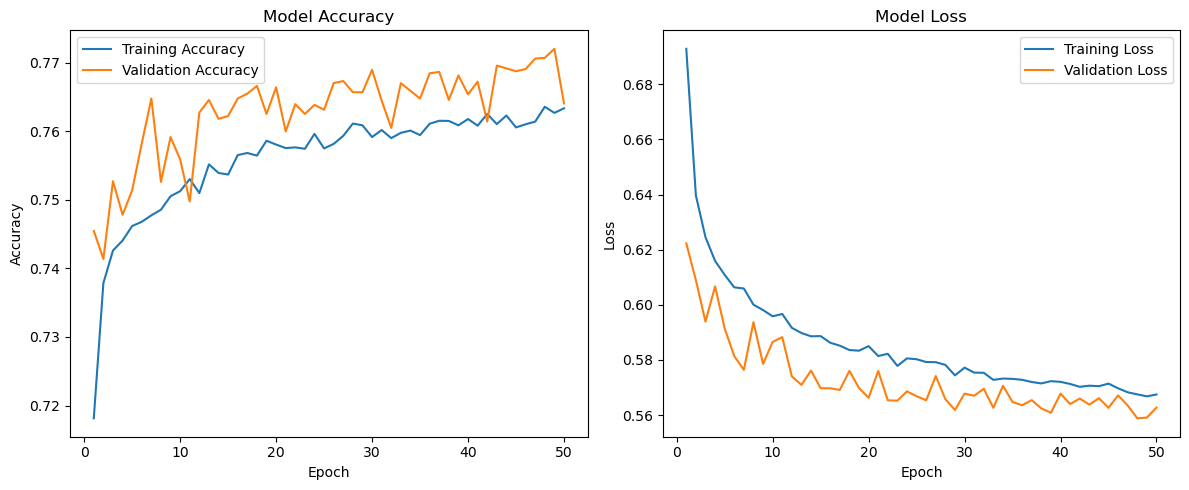

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


# normal model

In [47]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 512)                 │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 543,947 (2.07 MB)

 Trainable params: 181,315 (708.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 362,632 (1.38 MB)

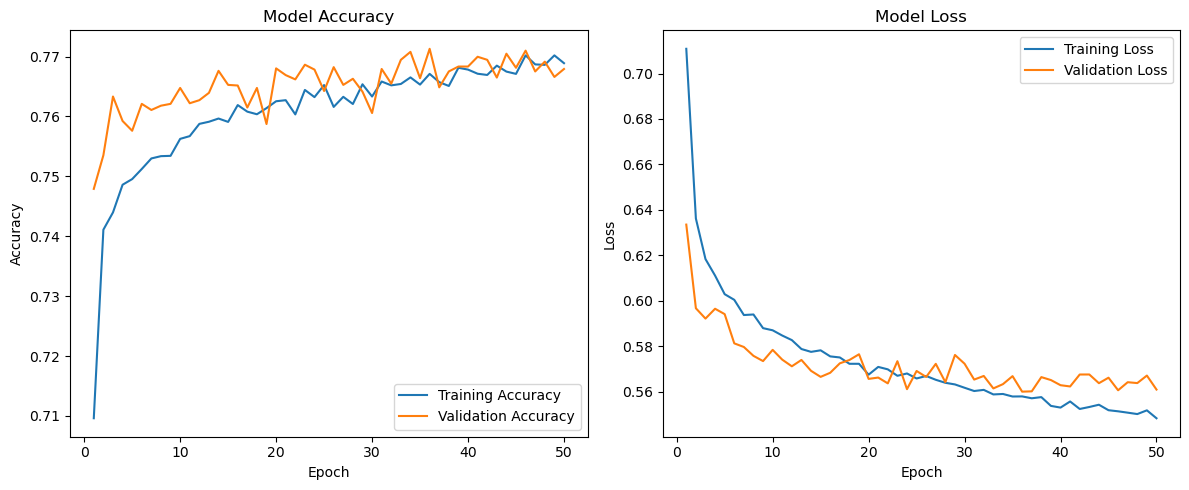

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


# normal model

In [51]:
from sklearn.metrics import classification_report
import numpy as np

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      6153
           1       0.76      0.80      0.78      4046
           2       0.78      0.60      0.68      2044

    accuracy                           0.77     12243
   macro avg       0.77      0.74      0.75     12243
weighted avg       0.77      0.77      0.77     12243



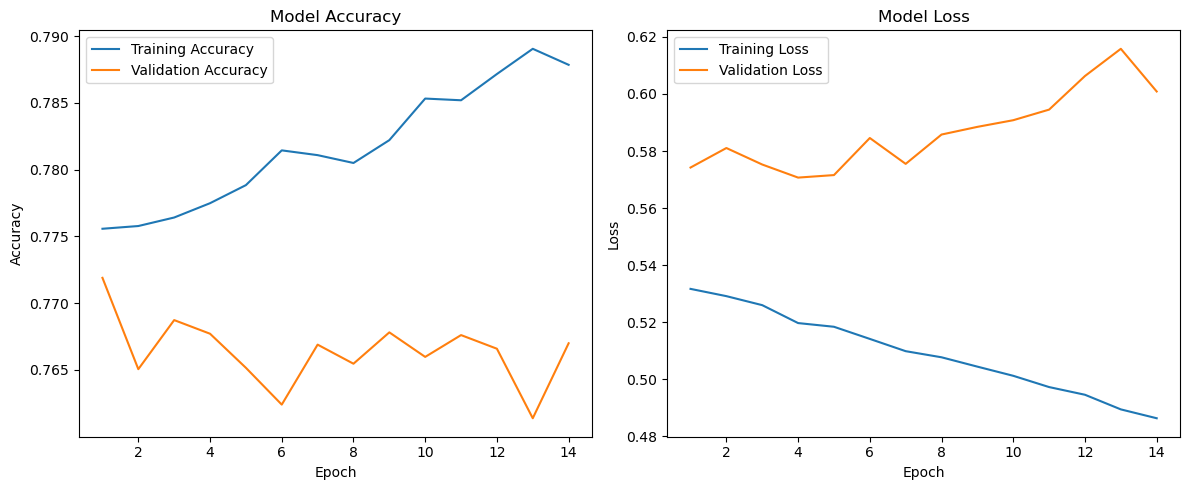

In [58]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


# normal model

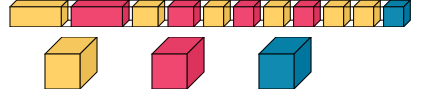

In [60]:
from PIL import ImageFont
import visualkeras
from tensorflow.keras import layers

# Load font
font = ImageFont.truetype("arial.ttf", 32)

# Add a Flatten layer to the model (or use your existing model)
model.add(layers.Flatten())

# Visualize model architecture using visualkeras
visualkeras.layered_view(model, legend=True, font=font)


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      6153
           1       0.76      0.80      0.78      4046
           2       0.78      0.60      0.68      2044

    accuracy                           0.77     12243
   macro avg       0.77      0.74      0.75     12243
weighted avg       0.77      0.77      0.77     12243



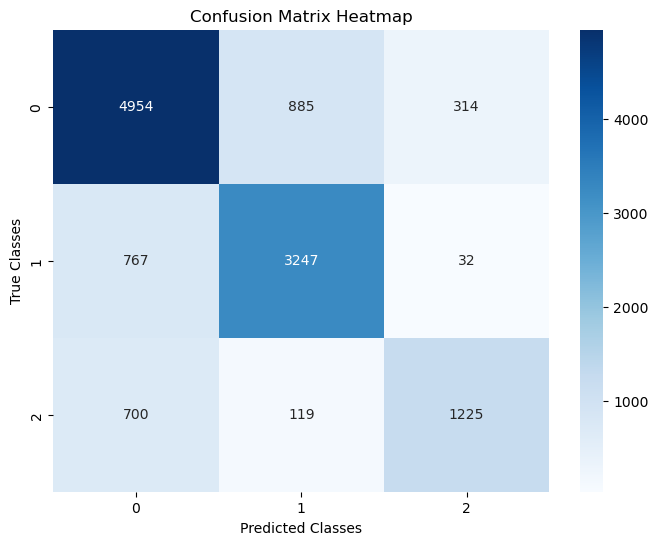

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_classes), yticklabels=np.unique(y_true_classes))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      6153
           1       0.77      0.77      0.77      4046
           2       0.78      0.60      0.68      2044

    accuracy                           0.76     12243
   macro avg       0.77      0.73      0.74     12243
weighted avg       0.77      0.76      0.76     12243



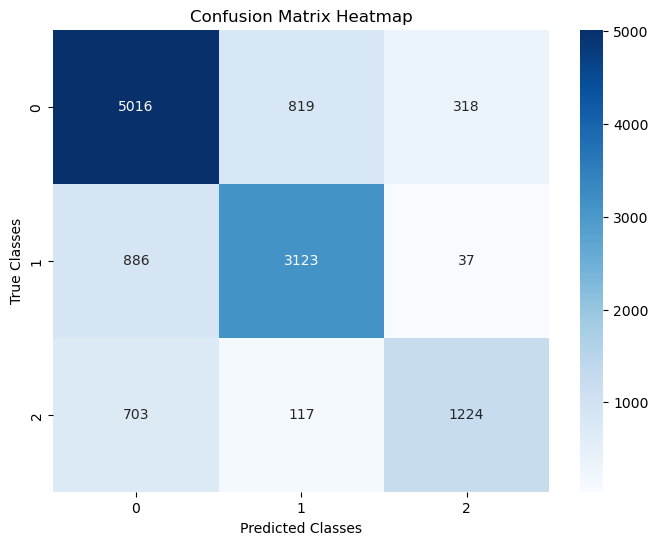

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict classes for the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_classes), yticklabels=np.unique(y_true_classes))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()
